In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

In [2]:
NA = 6.022e23
H1 = 6e26

In [3]:
def CNO1_cycle(elements, elemChart, temp=15e6):
    """
    Construct the differential equations for systems of the CNO1 cycle.
    
    Parameters
    ----------
    elements : np.array
        Numpy array containing the number densities of the elements.
    elemChart : dict
        Dictionary containing the positions of the elements in the elements array.
    temp : float
        Temperature of the system in K.
        
    Returns
    -------
    dX : dict
        The differential equations for the system.
    """
    
    t9 = temp/1e9 # convert to 10^9 K
    
    reaction_rates = {
        "C12(p,g)N13": 2.04e7/(t9**(2/3)) * np.exp(-13.690/(t9**(1/3)) - (t9/1.500)**2),
        "C13(p,g)N14": 8.01e7/(t9**(2/3)) * np.exp(-13.717/(t9**(1/3)) - (t9/2)**2),
        "N14(p,g)O15": 4.90e7/(t9**(2/3)) * np.exp(-15.228/(t9**(1/3)) - (t9/3.294)**2),
        "N15(p,a)C12": 1.08e12/(t9**(2/3)) * np.exp(-15.251/(t9**(1/3)) - (t9/0.522)**2)
    }
    
    # Assume all the N13 decays immediately to C13 and all the O15 decays immediately to N15
    
    C12toC13 = reaction_rates["C12(p,g)N13"] * elements[elemChart["C12"]] * elements[elemChart["H1"]] / NA
    C13toN14 = reaction_rates["C13(p,g)N14"] * elements[elemChart["C13"]] * elements[elemChart["H1"]] / NA
    N14toN15 = reaction_rates["N14(p,g)O15"] * elements[elemChart["N14"]] * elements[elemChart["H1"]] / NA
    N15toC12 = reaction_rates["N15(p,a)C12"] * elements[elemChart["N15"]] * elements[elemChart["H1"]] / NA
    
    
    dX = {
        'H1': -C12toC13 - N15toC12 - C13toN14 - N14toN15,
        'He4': N15toC12,
        'C12': N15toC12 - C12toC13,
        'C13': C12toC13 - C13toN14,
        'N14': C13toN14 - N14toN15,
        'N15': N14toN15 - N15toC12
    }

    return dX

In [4]:
def CNO2_cycle(elements, elemChart, temp=15e6):
    """
    Construct the differential equations for systems of the CNO1 cycle.
    
    Parameters
    ----------
    elements : np.array
        Numpy array containing the number densities of the elements.
    elemChart : dict
        Dictionary containing the positions of the elements in the elements array.
    temp : float
        Temperature of the system in K.
        
    Returns
    -------
    dX : dict
        The differential equations for the system.
    """
    
    t9 = temp/1e9 # convert to 10^9 K
    
    reaction_rates = {
        "N14(p,g)O15": 4.90e7/(t9**(2/3)) * np.exp(-15.228/(t9**(1/3)) - (t9/3.294)**2),
        "N15(p,g)O16": 9.78e8/(t9**(2/3)) * np.exp(-15.251/(t9**(1/3)) - (t9/0.450)**2),
        "O16(p,g)F17": 1.50e8/(t9**(2/3) * (1 + 2.13*(1 - np.exp(-0.728 * t9**(2/3))))) * np.exp(-16.692/(t9**(1/3))),
        "O17(p,a)N14": 1.53e7/(t9**(2/3)) * np.exp(-16.712/(t9**(1/3)) - (t9/0.565)**2)
    }
    
    # Assume all the O15 decays immediately to N15 and all the F17 decays immediately to O17
    
    N14toN15 = reaction_rates["N14(p,g)O15"] * elements[elemChart["N14"]] * elements[elemChart["H1"]] / NA
    N15toO16 = reaction_rates["N15(p,g)O16"] * elements[elemChart["N15"]] * elements[elemChart["H1"]] / NA
    O16toO17 = reaction_rates["O16(p,g)F17"] * elements[elemChart["O16"]] * elements[elemChart["H1"]] / NA
    O17toN14 = reaction_rates["O17(p,a)N14"] * elements[elemChart["O17"]] * elements[elemChart["H1"]] / NA
    
    dX = {
        "H1": -N14toN15 - N15toO16 - O16toO17 - O17toN14,
        "He4": O17toN14,
        "N14": O17toN14 - N14toN15,
        "N15": N14toN15 - N15toO16,
        "O16": N15toO16 - O16toO17,
        "O17": O16toO17 - O17toN14
    }
    
    return dX

In [5]:
def diffEqs(t, elements, elemChart, temp):
    """
    Construct the differential equations for the system.
    
    Parameters
    ----------
    t : float
        Time.
    elements : np.array
        Numpy array containing the number densities of the elements.
    elemChart : dict
        Dictionary containing the positions of the elements in the elements array.
    temp : float
        Temperature of the system in K.
        
    Returns
    -------
    dX : dict
        The differential equations for the system.
    """
    
    dCNO1 = CNO1_cycle(elements, elemChart, temp)
    dCNO2 = CNO2_cycle(elements, elemChart, temp)
    
    dX = np.zeros_like(elements)
    
    for key in dCNO1.keys():
        dX[elemChart[key]] = dCNO1[key]
        
    for key in dCNO2.keys():
        dX[elemChart[key]] = dCNO2[key]
    
    return dX

In [ ]:
elementMasses = {
    'H1': 1.007825,
    'He4': 4.002603,
    'C12': 12.000000,
    'C13': 13.003355,
    'N14': 14.003074,
    'N15': 15.000109,
    'O16': 15.994915,
    'F17': 17.002095,
    'O17': 16.999132
}

# Look up table for the elements to make our lives easier
elemChart = {
    'H1': 0,
    'H2': 1,
    'He3': 2,
    'He4': 3,
    'Li7': 4,
    'Be7': 5,
    'Be8': 6,
    'B8': 7,
    'C12': 8,
    'C13': 9,
    'N14': 10,
    'N15': 11,
    'O16': 12,
    'O17': 13,
}

initialAbundances = np.zeros(len(elemChart))

# Initial abundances which I found for the CNO cycles, add more for the other elements if and when needed
initialAbundances[elemChart['H1']] = H1
initialAbundances[elemChart['C12']] = H1*0.087
initialAbundances[elemChart['N14']] = H1*0.000082


14
14


In [7]:
t_start = 0.0
t_end   = 1e17

In [8]:
sols = solve_ivp(diffEqs, (t_start, t_end), initialAbundances, args=(elemChart, 15e6), method='Radau', rtol=1e-8, atol=1e-20)

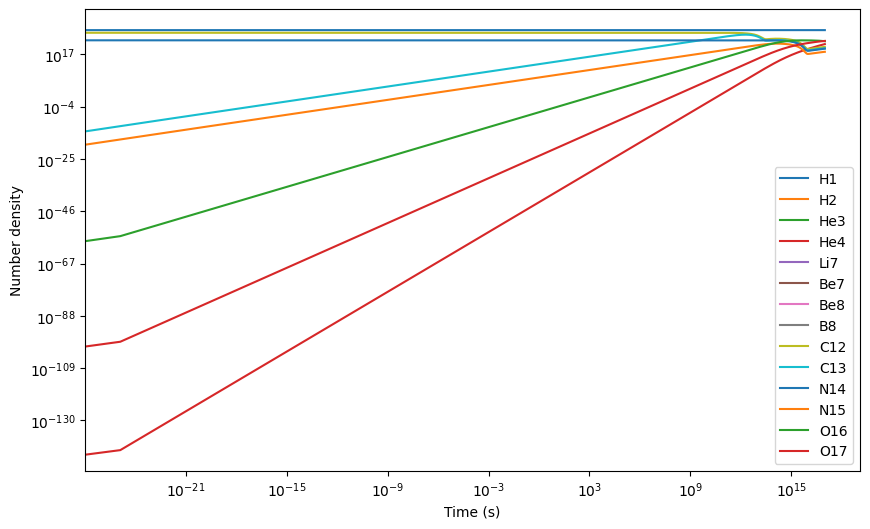

In [9]:
# Plot the results

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for key in elemChart.keys():
    ax.plot(sols.t, sols.y[elemChart[key]], label=key)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Number density')
ax.legend()
plt.show()
